### ESN application: Layer-wise relevance propagation baseESN on ENSO

Inspired by [Woodward et al., 2011](https://www.sacral.c.u-tokyo.ac.jp/pdf/woodward_ivcnz_2011.pdf) paper "A Reservoir Computing approach to Image Classification using Coupled Echo State and Back-Propagation Neural Networks", we want to reproduce some of their results, but with baseESN models alone. The idea is to take a whole sst anomaly field as input for the first timestep and couple each gridpoint to exactly one reservoir unit. After that we let the reservoir swing for some timesteps without feeding additional inputs and try to use final reservoir states for image classification. If that works, try LRP on this approach.

#### Data and derived sst anomaly index

SST data: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

Data contains **monthly mean SST** from 1854 .. 2021, in a 2° by 2° lat/lon grid:  
**lat:** 88N .. -88N (= 88S)  
**lon:** 0E .. 358E

Start from 1880. Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). However, recipe for calculating ENSO requires some rolling mean. We omit the rolling mean here and directly take **sst anomaly index** instead.

#### Outline

- Calculate sst anomaly index
- Classify sst anomaly fields: El Nino / La Nina
- Try linear regression and baseESN for comparison (**--> see first part in notebook: ESN_exp08_LRP.ipynb**)
- Optimize baseESN (hyper-)parameters (**--> see first part in notebook: ESN_exp08_LRP.ipynb**)
- Then try layer-wise relevance propagation, with MLP and baseESN (**--> see second part in notebook: ESN_exp08_LRP_part2.ipynb**)
- Continued with more perfection on layer-wise relevance propagation with base ESN (**--> see third part in notebook: ESN_exp08_LRP_part3.ipynb**)
- Classification and LRP with baseESN on **one-hot** targets, feeding inputs **column-wise** (**--> see fourth part in notebook: ESN_exp08_LRP_part4.ipynb**).
- here: **Coupled approach**, feed whole sst anomaly field in first timestep, **one by one connection** of reservoir units to gridpoints.

#### Sources

Google search results for "ESN for image classification" led to some promising papers:

* [Echo State Networks-based Reservoir Computing for MNIST Handwritten Digits Recognition](https://www.researchgate.net/figure/Inputs-and-outputs-of-a-ESN-for-image-classification-with-N-i-28_fig2_309033779)
* [On the Post-hoc Explainability of Deep Echo State Networks for Time Series Forecasting, Image and Video Classification](https://arxiv.org/abs/2102.08634) from Feb 2021
* [A Reservoir Computing approach to Image Classification using Coupled Echo State and Back-Propagation Neural Networks](https://www.sacral.c.u-tokyo.ac.jp/pdf/woodward_ivcnz_2011.pdf).
* [An image classification method based on Echo State Network](https://ieeexplore.ieee.org/document/9607999) from Nov 2021 (for purchase!)

### Tech preamble

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.special import softmax, expit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

import hvplot.xarray
import matplotlib.patches as patches

### Work with my own library of useful ESN functions
from ESN_functions_v05 import * 

### Load SST data

In [2]:
# Use, when working with relative path on local machine (or nesh)
sst_path = "../data/sst.mnmean.nc"
sst_dataset = xr.open_dataset(sst_path)
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2015, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-12-06

### Calculating SST anomaly index from sst data

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. Paper [Morrow et al., 2010] shows index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (here 1980-2009) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

**Note:** We omit smoothing with rolling mean here and hence call it *sst anomaly index* instead of *ENSO index*.

In [3]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = (
    sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01'))
    .sel(lat=slice(5,-5)).sel(lon=slice(190,240))
    .mean(("lat", "lon"))
)

# Compute monthly climatology (here: 1980-2009) for area averaged total SST from Niño 3.4 region.
# "Monthly" means grouping by month before calculating average over time.
sst_climatology_monthly = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .groupby("time.month")
    .mean("time")    
)

# Compute std dev in time for total climatology (here: 1980-2009), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_total_std = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

# Subtract monthly climatology from area averaged total SST time series to obtain anomalies
sst_anomaly_monthly = sst_mean.groupby("time.month") - sst_climatology_monthly

# ENSO index is calculated as 5 months rolling mean of sst anomaly.
# We aim to label time sclices of lat/lon grids according to their phase: "El Nino" / "La Nina".
# This requires sst_anomaly WITHOUT rolling mean!
# But still normalize sst anomaly by dividing by standard deviation of sst climatology, as done for ENSO index:
sst_anomaly_norm = sst_anomaly_monthly / sst_climatology_total_std

### Prepare inputs and targets

In third part of this experiment (**--> ESN_exp08_LRP_part3.ipynb**) we found some optimal setting, that requires:

* **Scale** inputs to [0,1].
* **Cap** 0.005% on each tail of sst anomaly fields' values.
* Since we want to feed whole world's sst anomaly fields as input samples, need to **reshape inputs**.

In [110]:
### Prepare inputs and targets for base ESN on sst anomaly fields

# Again get raw sst fields as lat/lon grids in time, from 1880 to date:
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2021-11-01'))
    #.sel(lat=slice(70,-65))#.sel(lon=slice(150,280))  ### Only, if we don't want to take whole worlds sst fields!
)

# Compute monthly climatology (here 1980 - 2009) for whole world
sst_climatology_fields = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
    #.sel(lat=slice(70,-65))#.sel(lon=slice(150,280))  ### Only, if we don't want to take whole worlds sst fields!
)

# Get sst anomaly fields by subtracting monthly climatology from raw sst fields:
sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

# Only keep sst anomaly fields connected either El Nino or La Nina event.
sst_anomaly_fields_NinoNina = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Extract sst anomaly fields' values as iputs:
inputs = np.copy(sst_anomaly_fields_NinoNina.values)

# Replace nan values by ZERO
inputs[np.isnan(inputs)] = 0

# It might be a problem to first set nan values to zero, then apply min/max scaling.
# After scaling former nan values are non-zero!
# On the other hand we cannot get necessary min/max values as long as we have nan values.
# Solution: Replace nan by zero. Apply min/max scaling. Then again set former nan values to zero.

# Check how many nan values we have:
temp_isnan = np.isnan(sst_anomaly_fields_NinoNina.values)
temp_isnan_rel = sum(sum(sum(temp_isnan))) / (temp_isnan.shape[0] * temp_isnan.shape[1] * temp_isnan.shape[2])
print("rel. amount of nan values in inputs BEFORE modification: ", np.round(temp_isnan_rel,2))

# Check how many 'weird' values we have, stemming from Arctic ice coverage:
temp_weird = (sst_anomaly_fields_NinoNina.values==-4.7683716e-07)

# Get targets from sst anomaly index:
targets = sst_anomaly_norm.values[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Also convert targets to binary targets (1 / 0) for El Nino / La Nina.
targets_bin = (targets > 0.5).astype(int)

# Reshape targets to (samples, 1):
targets = targets.reshape((len(targets), 1))
targets_bin = targets_bin.reshape((len(targets_bin), 1))

# Create one-hot targets for two unit output (El Nino / La Nina):
targets_onehot = np.concatenate([(targets_bin==1).astype(int),(targets_bin==0).astype(int)], axis=1)

## Split inputs and targets into train and validation data according to train_val_split.

# Set rel. amount of samples used for training:
train_val_split = 0.8

# Get number of train samples:
n_train = int(len(inputs) * train_val_split)

# get quantile min/max for for specified X% quantile on train data (year 2002..2015)
quantile_perc = 0.005 #e.g. 0.005 to cap 0.5% at lower AND upper edge of distribution
q_lower_limit = np.quantile(inputs.flatten(), quantile_perc)
q_upper_limit = np.quantile(inputs.flatten(), 1 - quantile_perc)

# Cap inputs with values outside quantile limits:
inputs[inputs > q_upper_limit] = q_upper_limit
inputs[inputs < q_lower_limit] = q_lower_limit

## Scale inputs to [-1,1] or [0,1] according to min/max obtained from only train inputs.

# Remenber min/max used for scaling.
train_min = np.min(inputs[:n_train])
train_max = np.max(inputs[:n_train])

# Scale to either [-1,1]:
inputs = 2 * (inputs - train_min) / (train_max - train_min) - 1

# Alternatively scale inputs to [0,1]
#inputs = (inputs - train_min) / (train_max - train_min)

# Again set former nan values to zero after scaling:
inputs = inputs * np.invert(temp_isnan)

## Again set former 'weird' values to zero after scaling:
#inputs = inputs * np.invert(temp_weird)

## Reduce inputs' dimension by a factor of 2 for both, lat and lon: Only take every second gridpoint into account.
inputs = inputs[:,np.arange(0,inputs.shape[1],2),:]
inputs = inputs[:,:,np.arange(0,inputs.shape[2],2)]

# Reshape inputs to (samples, 1, features), since we want to feed whole sst anomaly fields 
# with its lat x lon features in one timestep:
inputs = np.reshape(inputs, (inputs.shape[0], 1, inputs.shape[1] * inputs.shape[2]))

# Split inputs and targets:
train_input = inputs[:n_train]
val_input = inputs[n_train:]
train_target = targets[:n_train]
val_target = targets[n_train:]
train_target_bin = targets_bin[:n_train]
val_target_bin = targets_bin[n_train:]
train_target_onehot = targets_onehot[:n_train]
val_target_onehot = targets_onehot[n_train:]

## Additionally scale targets to [-1,1] according to min/max obtained from only train targets.
# Remenber min/max used for scaling.
train_target_min = np.min(train_target)
train_target_max = np.max(train_target)
# Scale
train_target_scaled = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
val_target_scaled = 2 * (val_target - train_target_min) / (train_target_max - train_target_min) - 1

# Dimensionality check:
print("\ninputs shape (all input samples): ", inputs.shape)
print("train_input shape: ", train_input.shape)
print("val_input shape: ", val_input.shape)
print("\ntargets shape (all targets): ", targets.shape)
print("train_target shape: ", train_target.shape)
print("val_target shape: ", val_target.shape)
print("train_target_onehot shape: ", train_target_onehot.shape)
print("val_target_onehot shape: ", val_target_onehot.shape)
print("\ntrain_inputs min: ", train_min)
print("train_inputs max: ", train_max)
print("\nscaled train_inputs min: ", np.min(train_input))
print("scaled train_inputs max: ", np.max(train_input))
print("scaled val_inputs min: ", np.min(val_input))
print("scaled val_inputs max: ", np.max(val_input))
print("\nun-scaled train_target min: ", np.min(train_target))
print("un-scaled train_target max: ", np.max(train_target))
print("un-scaled val_target min: ", np.min(val_target))
print("un-scaled val_target max: ", np.max(val_target))
print("\nscaled train_target min: ", np.min(train_target_scaled))
print("scaled train_target max: ", np.max(train_target_scaled))
print("scaled val_target min: ", np.min(val_target_scaled))
print("scaled val_target max: ", np.max(val_target_scaled))

rel. amount of nan values in inputs BEFORE modification:  0.31

inputs shape (all input samples):  (1039, 1, 4050)
train_input shape:  (831, 1, 4050)
val_input shape:  (208, 1, 4050)

targets shape (all targets):  (1039, 1)
train_target shape:  (831, 1)
val_target shape:  (208, 1)
train_target_onehot shape:  (831, 2)
val_target_onehot shape:  (208, 2)

train_inputs min:  -2.2602541
train_inputs max:  1.6804371

scaled train_inputs min:  -1.0
scaled train_inputs max:  1.0
scaled val_inputs min:  -1.0
scaled val_inputs max:  1.0

un-scaled train_target min:  -2.8181634
un-scaled train_target max:  2.4123752
un-scaled val_target min:  -1.7919745
un-scaled val_target max:  2.7960107

scaled train_target min:  -1.0
scaled train_target max:  1.0
scaled val_target min:  -0.60761636
scaled val_target max:  1.1466906


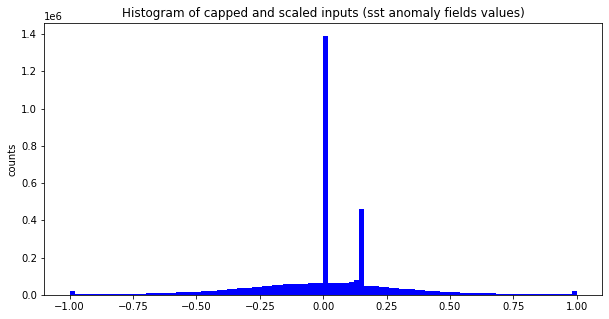

In [75]:
# Plot histogram of scaled inputs:
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(inputs.flatten(), nBins, color="blue")
axes.set_ylabel("counts")
axes.set_title("Histogram of capped and scaled inputs (sst anomaly fields values)")
plt.show()

### Artefact of Feature?

Observe former nan values to be correctly set to zero. But where does that second peak come from?
It turns out that it stems from Artic region. So far it has not disturbed prediction accuracy when feeding sst anomaly fields column-wise into base ESN models. But it could cause trouble when feeding samples row-wise into model! **--> That needs to be further investigated!**

**Note:** This second peak appears not only if we scale inputs to [0,1], but also When scaling to [-1,1].

In [22]:
# Find strange second peak in histogram of capped and scaled inputs at 0.5735678
inputs[0,0,:10]

# Look at source sst_anomaly_fields_NinoNina.values, find unscaled raw value of -4.7683716e-07
np.sum((sst_anomaly_fields_NinoNina.values==-4.7683716e-07))

# But sst_anomaly_fields_NinoNina is obtained as difference of sst_fields and sst_climatology_fields:
# sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields
# First input sample is then obtained as first sample of sst_anomaly_fields with sst_anomaly_norm.values>0.5
(sst_anomaly_norm.values>0.5)[69]

True

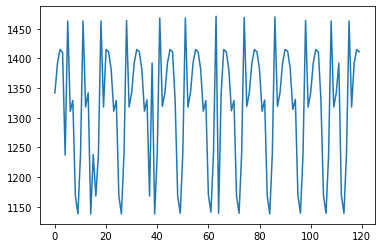

In [21]:
# Check periodicity, but note: Here we only have samples related to either El Nino or La Nina event:
plt.plot(np.sum((sst_anomaly_fields_NinoNina.values==-4.7683716e-07),axis=(1, 2))[:120])

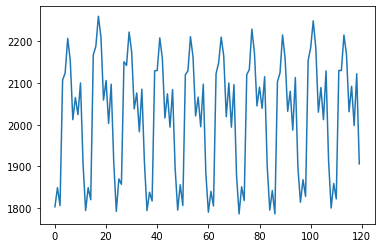

In [25]:
# Strange value is seen as -1.8 in raw sst_fields. Check periodicity: Expect T=12months, hence these values
# are possibly related to Arctic ice coverage.

plt.plot(np.sum((sst_fields.values==-1.8), axis=(1, 2))[:120])

In [25]:
sst_fields[69]

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1885-10-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [27]:
sst_climatology_fields[:,0,0]

<xarray.DataArray 'sst' (month: 12)>
array([-1.7999995, -1.7999995, -1.7999995, -1.7999995, -1.7999995,
       -1.7999995, -1.7999995, -1.7999995, -1.7999995, -1.7999995,
       -1.7999995, -1.7999995], dtype=float32)
Coordinates:
    lat      float32 88.0
    lon      float32 0.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

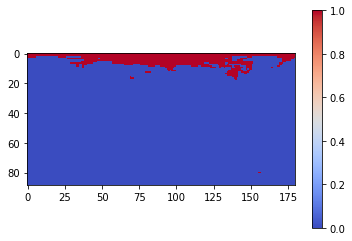

In [19]:
# Check first sample for that value of interest:
temp_sample = sst_anomaly_fields_NinoNina.values[0]==-4.7683716e-07

# Show as heatmap:
plt.imshow(temp_sample, cmap='coolwarm', interpolation='nearest')#, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

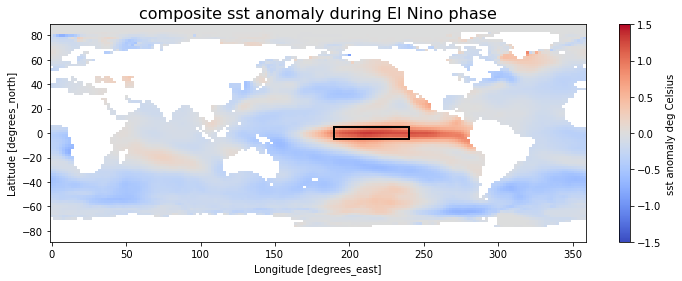

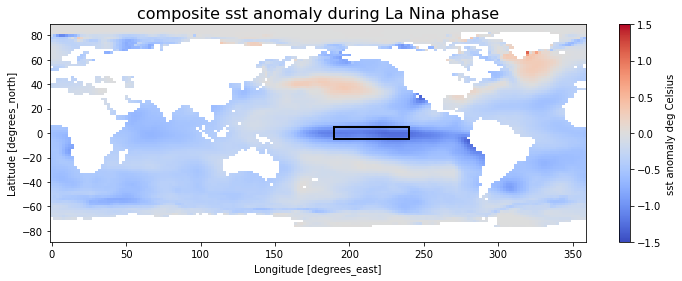

In [39]:
## Split sst anomaly fields related to El Nino or La Nina, respectively:

# El Nino
sst_anomaly_fields_ElNino = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5)]

# La Nina
sst_anomaly_fields_LaNina = sst_anomaly_fields[(sst_anomaly_norm.values < -0.5)]

## Get mean sst anomaly field as composit of all sst fields belonging to either "El Nino" or "La Nina":

# El Nino
sst_anomaly_mean_ElNino = (
    sst_anomaly_fields_ElNino
    .mean("time")
)

# La Nina
sst_anomaly_mean_LaNina = (
    sst_anomaly_fields_LaNina
    .mean("time")
)

## Plot sst anomaly fields for the world, with bounding box arround Nino3.4 area

# El Nino
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_mean_ElNino.name = 'sst anomaly deg Celsius'
sst_anomaly_mean_ElNino.plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('composite sst anomaly during El Nino phase', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# La Nina
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_mean_LaNina.name = 'sst anomaly deg Celsius'
sst_anomaly_mean_LaNina.plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('composite sst anomaly during La Nina phase', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

In [57]:
## Final check if samples are balanced, hence if we find equal number of EL Nino and La Nina events 
## in train and validation data:

print("ALL samples:")
print("rel. amount of El Nino samples: ", np.round(sum(targets_bin[:,0]==1)/len(targets),2))
print("rel. amount of La Nina samples: ", np.round(sum(targets_bin[:,0]==0)/len(targets),2))

print("\nTRAIN samples:")
print("rel. amount of El Nino samples: ", np.round(sum(train_target_bin[:,0]==1)/len(train_target),2))
print("rel. amount of La Nina samples: ", np.round(sum(train_target_bin[:,0]==0)/len(train_target),2))

print("\nVALIDATION samples:")
print("rel. amount of El Nino samples: ", np.round(sum(val_target_bin[:,0]==1)/len(val_target),2))
print("rel. amount of La Nina samples: ", np.round(sum(val_target_bin[:,0]==0)/len(val_target),2))

ALL samples:
rel. amount of El Nino samples:  0.28
rel. amount of La Nina samples:  0.72

TRAIN samples:
rel. amount of El Nino samples:  0.23
rel. amount of La Nina samples:  0.77

VALIDATION samples:
rel. amount of El Nino samples:  0.47
rel. amount of La Nina samples:  0.53


### Discussion on samples' balance

We find class imbalance: Have a lot more La Nina samples than El Nino samples, at least in train data. This should not be a problem for ESN models if we work with one-hot targets and train output weights for each class in a closed-form manner. And this is obviously another advantage compared to *regular* ANN architectures!

### Classification with coupled baseESN


#### Base parameter setup

* Since we want to couple each gridpoint of sst anomaly fields to exactly one reservoir unit, hence **n_res = lat x lon gridpoints**.
* **Input weights** $W_{in}$ are manually adjusted and take the form of a diagonal matrix with *ones* on the main diagonal and *zeros* everywhere else.
* Optionally set **input and reservoir biases** to *zero*, to avoid the need to consider weights in backpropagation of relevance.
* **leak_rate** is set to one in first attempt, to keep recursion as simple as possible.
* spec_radius = 0.8
* sparsity = 0.3

**Note:** We have **reduced input dimension by a factor of 4** by only taking every second gridpoint (in lat and lon) into account. This step is necessary to avoid runtime explosion during model setup, which requires computing eigenvalues of reservoir weight matrix and runtime scales with $n_{res}^2$.

**Multiplication with $\alpha$** is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*). 

Use these parameters on normalmized sst anomaly fields - **scaled** to either [0,1] with **sigmoid** activation or scaled to [-1,1] with **tanh** activation - as inputs and **one-hot targets**. 

And apply **capping** to keep inputs in certain specified quantile limits to enhance scaling.

**input_length** determines how long we let the reservoir swing, wighout additional inputs. Again: We only feed the whole flattened sst anomaly field into the ESN model in the first timestep. To achieve multiple timesteps, need to adjust train and validation inputs by adding *zeros* for subsequent timesteps. 

**Note:** Without additional timesteps we have no recursion in reservoir and just apply some linear regression on *activated* inputs.

In [111]:
### Try classification of sst anomaly fields with coupled base ESN. Define parameters for ESN model upfront
verbose = True
input_length = 2 # Number of input timesteps. Note: Feed sst anomaly field as first input (t=1).
                 # For additional timesteps feed only zeros into ESN model.
                 # Need at least 2 timesteps to correctly set up ESN model with at least one recursion in reservoir.
n_layers = 1 # Number of ESN layers in the model.
n_res = train_input.shape[2] # Number of reservoir units needs to equal number of input features (lat x lon).
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
               # Note: Not needed for coupled approach, since we manually modify input weights.
leak_rate = 1 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 2 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events.

In [112]:
# Modify train and validation inputs by adding zeros for additional timesteps.
train_input_add = np.zeros((train_input.shape[0], input_length - 1, train_input.shape[2]))
val_input_add = np.zeros((val_input.shape[0], input_length - 1, val_input.shape[2]))

# Concat former train and validation inputs with additional zeros:
train_input = np.concatenate([train_input, train_input_add], axis=1)
val_input = np.concatenate([val_input, val_input_add], axis=1)

print("train input shape (samples, timesteps, features): ", train_input.shape)
print("val input shape (samples, timesteps, features): ", val_input.shape)

train input shape (samples, timesteps, features):  (831, 2, 4050)
val input shape (samples, timesteps, features):  (208, 2, 4050)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1, 4050)]         0         
_________________________________________________________________
esn_6 (ESN)                  ((None, 1, 4050), (None,  16406550  
_________________________________________________________________
output (Dense)               (None, 2)                 8102      
Total params: 16,414,652
Trainable params: 16,414,652
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1, 4050)]         0         
_________________________________________________________________
esn_6 (ESN)                  ((None, 1, 4050), (None,  16406550  
Total params: 16,406,550
Tra

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1067/3403742564.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (831, 1, 4050)
shape of model output X_T (samples, n_res):  (831, 4050)

Final reservoir states in augmented notation, shape:  (831, 4051)

train_target shape (samples, output features):  (831, 2)

W_out shape:  (4050, 2)
b_out shape:  (2,)

output feature  0 , trained b_out:  [0.06951081]


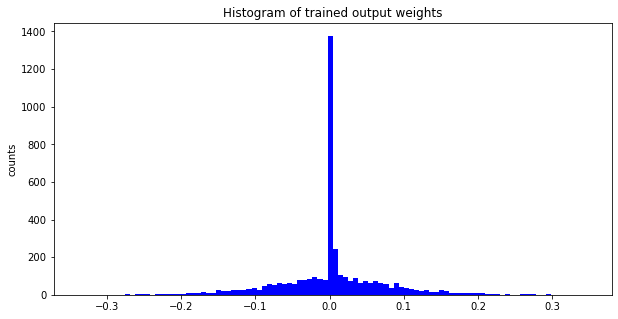


output feature  1 , trained b_out:  [0.09645103]


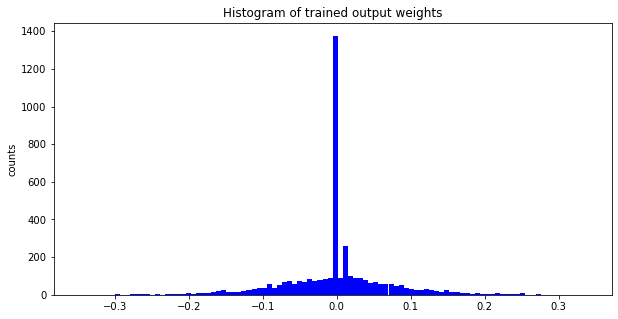


shape of val input (samples, timesteps, features):  (208, 1, 4050)
shape of train input (samples, timesteps, features):  (831, 1, 4050)

shape of model predictions on validation input (samples, 1):  (208, 2)
shape of val targets (samples, 1):  (208, 2)

train_mae:  0.0
val_mae:  0.35

train_mse:  0.0
val_mse:  0.1818


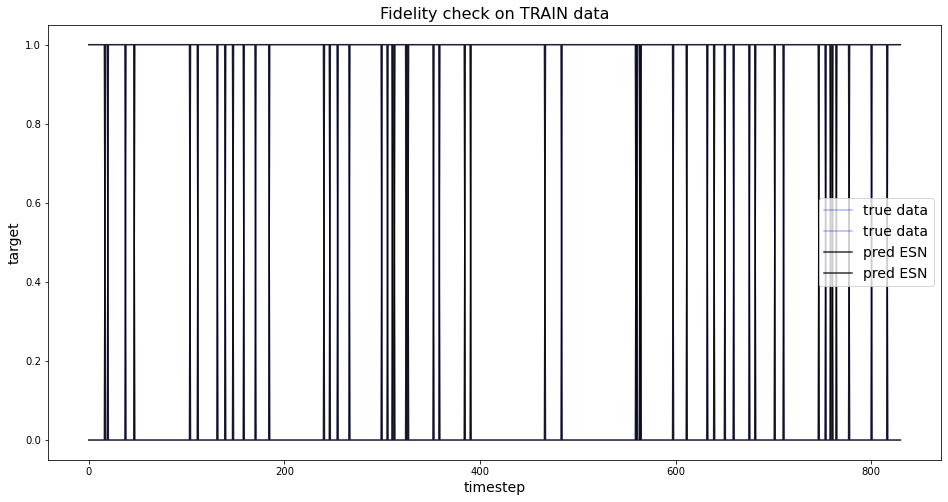

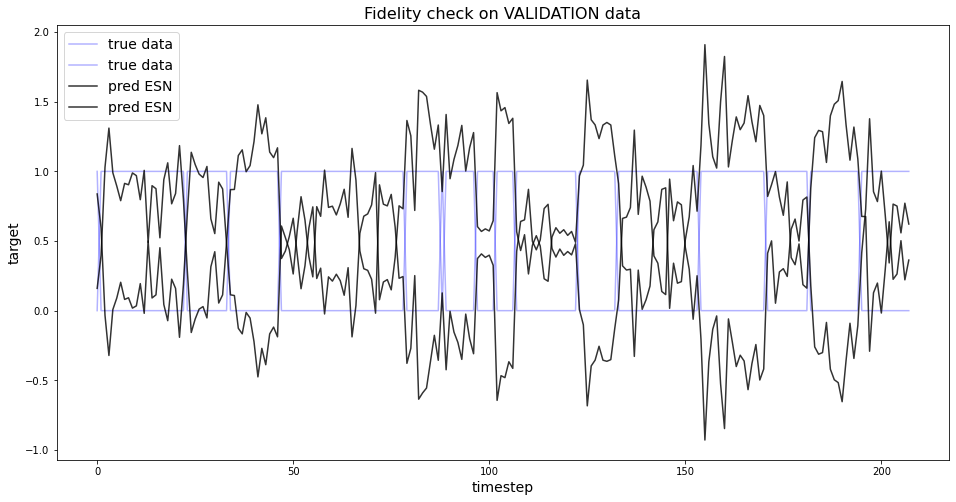

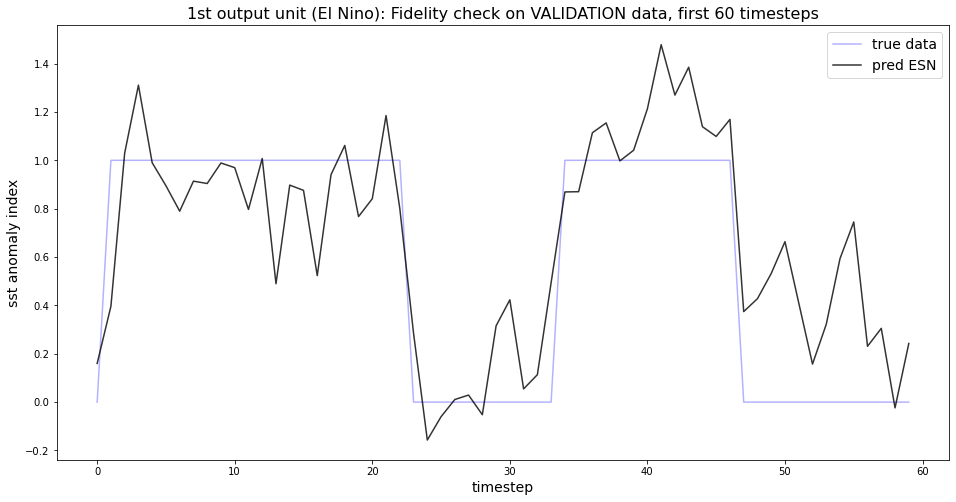

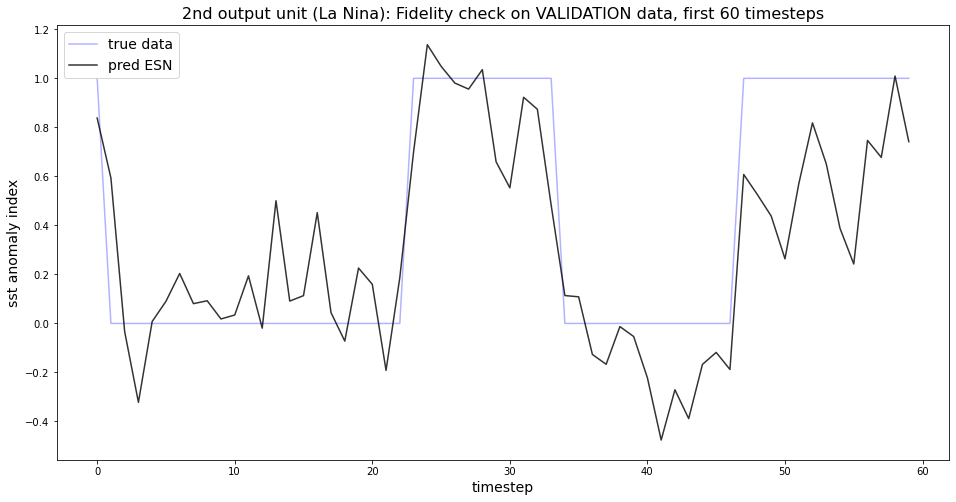

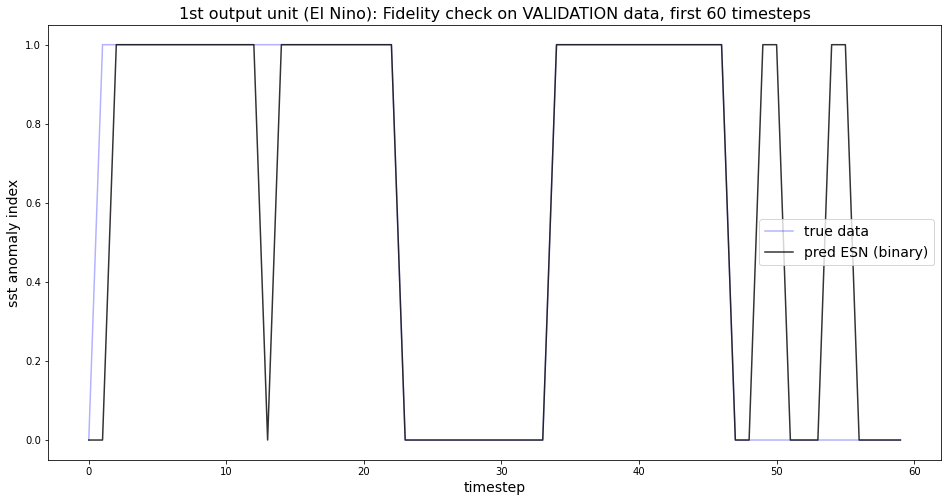

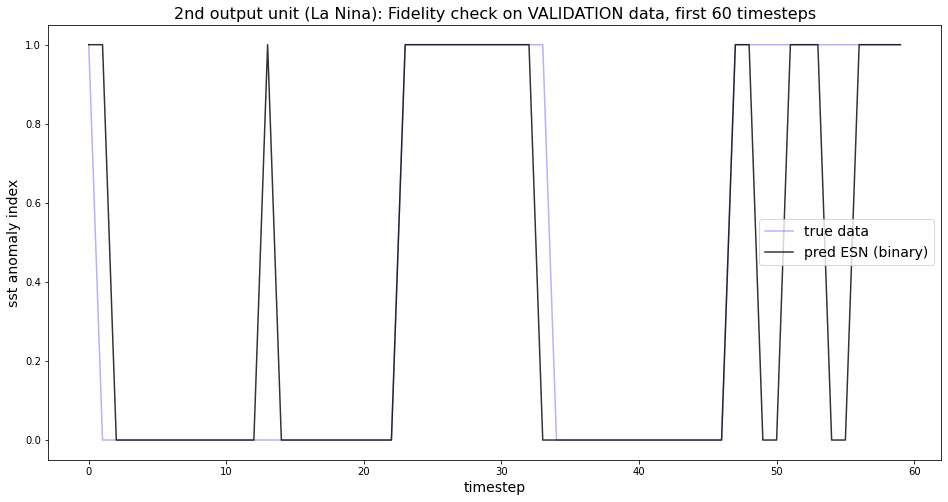


Validation accuracy:
El Nino:  0.98
La Nina:  0.98

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [70]:
#### Special case: input_length = 1

# In this case we just feed the input into our coupled base ESN and don't let the reservoir swing.
# Hence reservoir weights are not needed and cause trouble in function setESN.
# Avoid error message by setting up model manually, as follows:
   
## Set up model

# Input layer
model_inputs = Input(shape=(input_length, in_features)) # (timesteps, input features)

# Set up storage for layers' final reservoir state tensors:    
X_T_all = []

## Loop for setting up desired number of ESN layers:
for l in range(n_layers):

    # First ESN needs to be connected to model_inputs:
    if l == 0:

        # Use custom layer for setting up reservoir, returns ALL reservoir states X and FINAL reservoir states X_T.
        X, X_T = ESN(n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                     leak_rate_first_step_YN=leak_rate_first_step_YN,
                     activation=activation)(model_inputs)

        # Store resulting final reservoir states:            
        X_T_all.append(X_T)

    # Further ESN layers need to be connected to previous ESN layer:
    else:

        # Use new custom layer for setting up reservoir, again returns ALL reservoir states X and 
        # FINAL reservoir states X_T.
        X, X_T = ESN(n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                     leak_rate_first_step_YN=leak_rate_first_step_YN,
                     activation=activation)(X)

        # Store resulting final reservoir states:            
        X_T_all.append(X_T)

## Concatenate final reservoir states from ALL layers before passing result to output layer:

# In case we only have ONE layer, no concatenation is required:
if n_layers == 1:
    X_T_concat = X_T_all[0]

# Else concatenate stored final reservoir states using lambda-function:
else:
    X_T_concat = Lambda(lambda x: concatenate(x, axis=-1))(X_T_all)

# Output unit
output = Dense(units=out_features, activation=None, use_bias=True, 
               kernel_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
               bias_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
               name='output')(X_T_concat)

# Define complete model "model" plus short model "model_short" omitting the output layer, 
# for getting reservoir states for given inputs.
model = Model(model_inputs, output, name='model')
model_short = Model(model_inputs, X_T_concat, name='model_short')

# Define another shortened model "all_states" to get all reservoir states X from last ESN layer:
all_states = Model(model_inputs, X, name='all_states')    

# Optionally reveal model summaries
if verbose:

    # Print model summaries
    model.summary()
    model_short.summary()  
    
### Adjust input weights, set input and reservoir biases to zero.

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_out = model_weights[2]
b_out = model_weights[3]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Prepare zero input biases:
b_in_zeros = np.zeros(b_in.shape)
model_weights[1] = b_in_zeros

## Prepare input weights having ONE on main diagonal and ZERO elsewhere:
W_in_diag = np.zeros((n_res,n_res))
for i in range(n_res):
    W_in_diag[i,i]=1
model_weights[0] = W_in_diag

# Get modified weights and biases back into the model
model.set_weights(model_weights)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input, train_target_onehot, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target_onehot, val_target_onehot,
                                                                       verbose=verbose)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 1st output unit (El Nino)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,0])),val_pred[:60,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 2nd output unit (La Nina)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,1])),val_pred[:60,1],'k',  alpha=0.8, label='pred ESN')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5)
val_pred_bin = (val_pred > 0.5)

if verbose:
    # Fidelity check for binary prediction and target for 1st output unit (El Nino).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,0])),val_pred_bin[:60,0],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check for binary prediction and target for 2nd output unit (La Nina).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,1])),val_pred_bin[:60,1],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_onehot[:,0]) & (val_target_onehot[:,0] == 1)) / sum(val_target_onehot[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,1] == val_target_onehot[:,1]) & (val_target_onehot[:,1] == 0)) / sum(val_target_onehot[:,1] == 0)


# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_onehot[:,0]) & (train_target_onehot[:,0] == 1)) / sum(train_target_onehot[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,1] == train_target_onehot[:,1]) & (train_target_onehot[:,1] == 0)) / sum(train_target_onehot[:,1] == 0)

if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

In [113]:
##### For input_length > 1:

# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:712: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2, 4050)]         0         
_________________________________________________________________
esn_10 (ESN)                 ((None, 2, 4050), (None,  32813100  
_________________________________________________________________
output (Dense)               (None, 2)                 8102      
Total params: 32,821,202
Trainable params: 32,821,202
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2, 4050)]         0         
_________________________________________________________________
esn_10 (ESN)                 ((None, 2, 4050), (None,  32813100  
Total params: 32,813,100
Tra

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:751: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1067/3065355175.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (4050, 4050)
input biases b_in (res. units):  (4050,)
reservoir weights W_res (res. units, res. units):  (4050, 4050)
reservoir biases b_res (res. units):  (4050,)
output weights W_out (res. units, output features):  (4050, 2)
output biases b_out (output features):  (2,)


/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (831, 2, 4050)
shape of model output X_T (samples, n_res):  (831, 4050)

Final reservoir states in augmented notation, shape:  (831, 4051)

train_target shape (samples, output features):  (831, 2)

W_out shape:  (4050, 2)
b_out shape:  (2,)

output feature  0 , trained b_out:  [0.24791475]


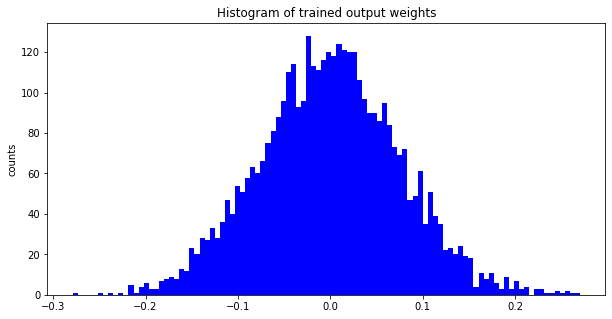


output feature  1 , trained b_out:  [0.05940348]


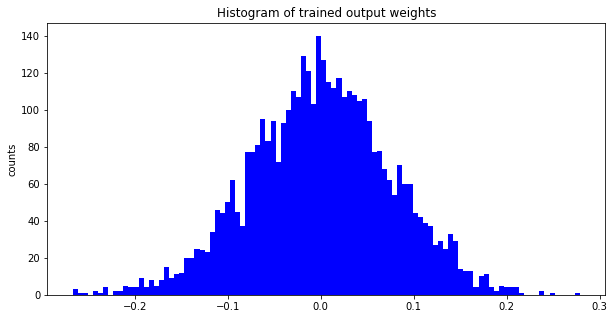


shape of val input (samples, timesteps, features):  (208, 2, 4050)
shape of train input (samples, timesteps, features):  (831, 2, 4050)

shape of model predictions on validation input (samples, 1):  (208, 2)
shape of val targets (samples, 1):  (208, 2)

train_mae:  0.0
val_mae:  0.2243

train_mse:  0.0
val_mse:  0.0839


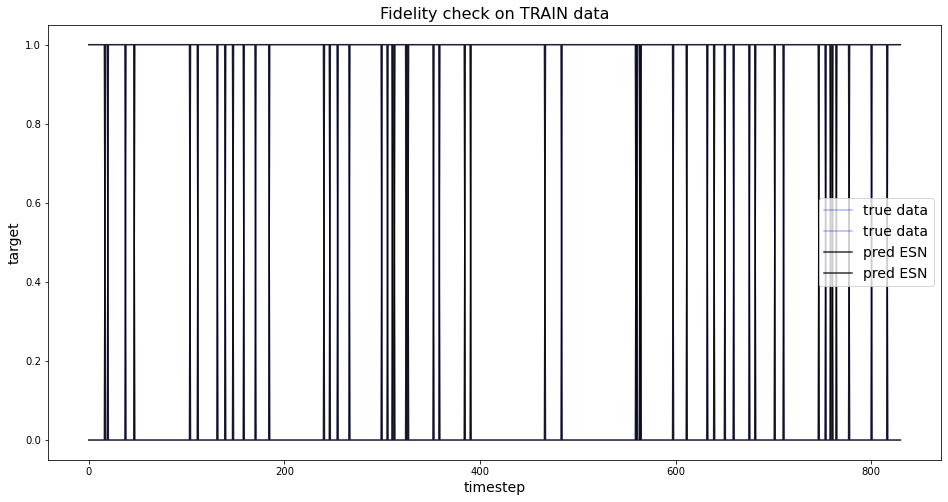

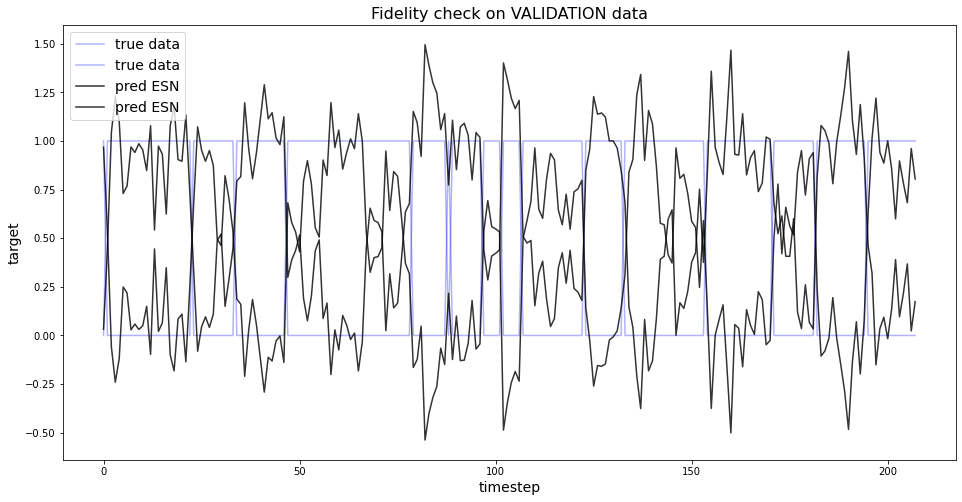

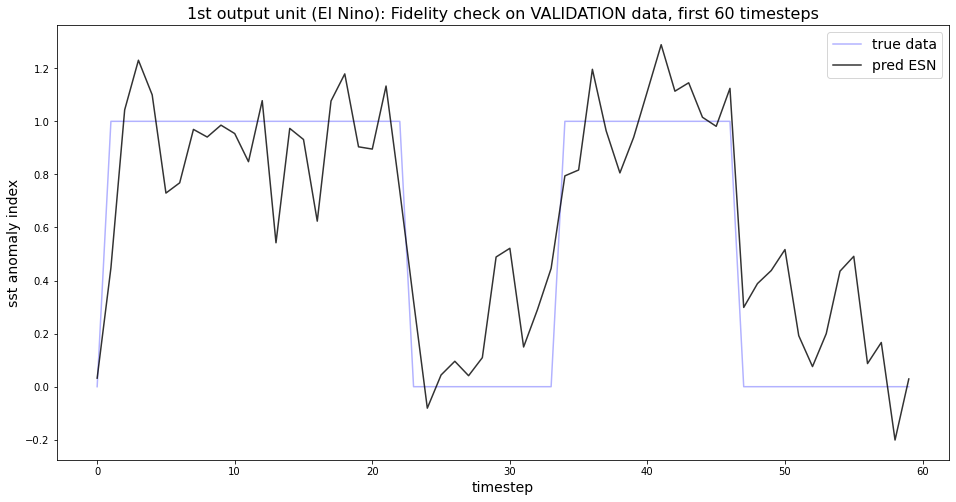

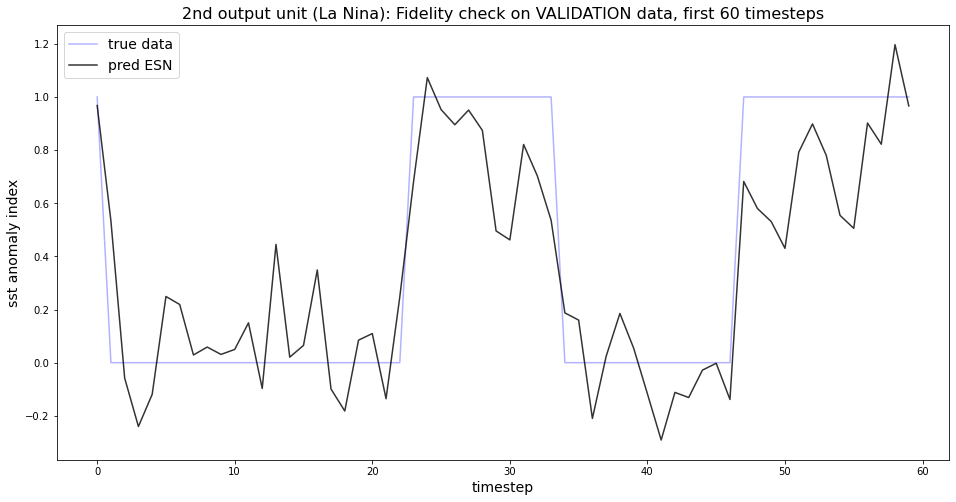

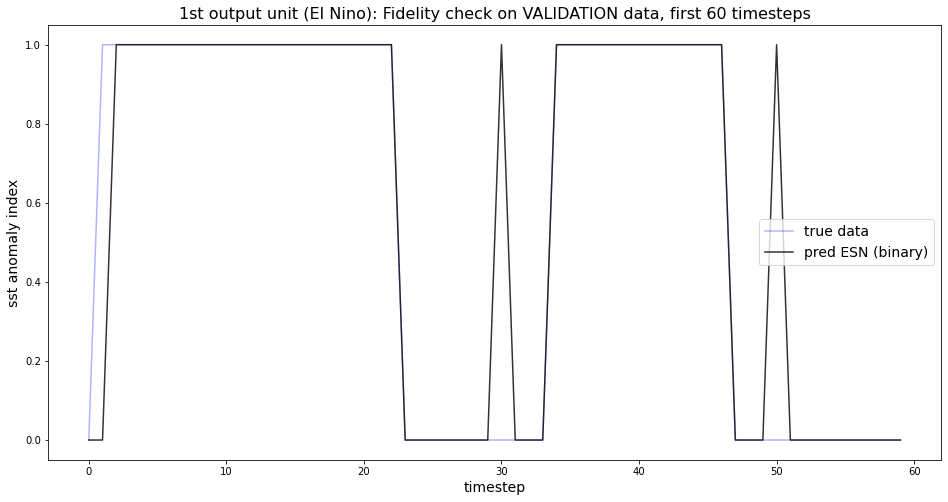

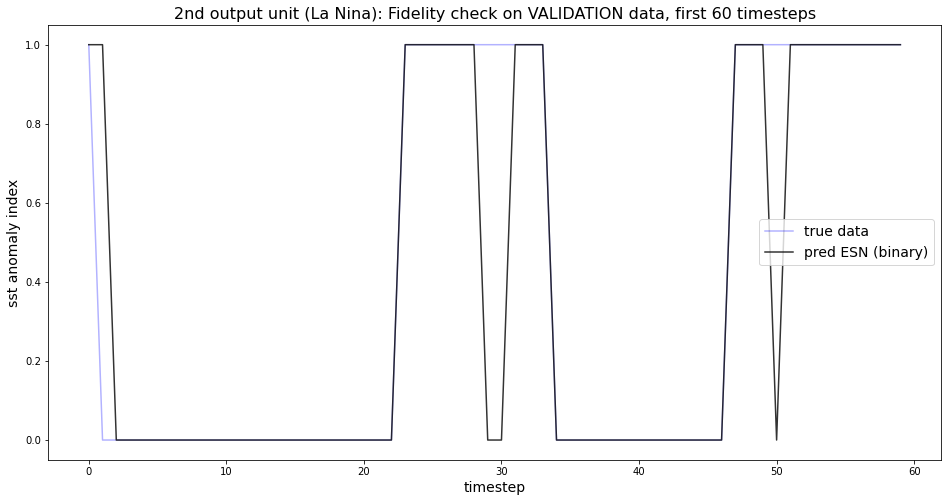


Validation accuracy:
El Nino:  0.99
La Nina:  0.99

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [114]:
### Adjust input weights, set input and reservoir biases to zero.

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Prepare zero input and reservoir biases:
b_in_zeros = np.zeros(b_in.shape)
b_res_zeros = np.zeros(b_res.shape)
model_weights[1] = b_in_zeros
model_weights[3] = b_res_zeros

## Prepare input weights having ONE on main diagonal and ZERO elsewhere:
W_in_diag = np.zeros((n_res,n_res))
for i in range(n_res):
    W_in_diag[i,i]=1
model_weights[0] = W_in_diag

# Get modified weights and biases back into the model
model.set_weights(model_weights)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input, train_target_onehot, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target_onehot, val_target_onehot,
                                                                       verbose=verbose)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 1st output unit (El Nino)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,0])),val_pred[:60,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 2nd output unit (La Nina)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,1])),val_pred[:60,1],'k',  alpha=0.8, label='pred ESN')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5)
val_pred_bin = (val_pred > 0.5)

if verbose:
    # Fidelity check for binary prediction and target for 1st output unit (El Nino).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,0])),val_pred_bin[:60,0],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check for binary prediction and target for 2nd output unit (La Nina).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,1])),val_pred_bin[:60,1],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_onehot[:,0]) & (val_target_onehot[:,0] == 1)) / sum(val_target_onehot[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,1] == val_target_onehot[:,1]) & (val_target_onehot[:,1] == 0)) / sum(val_target_onehot[:,1] == 0)


# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_onehot[:,0]) & (train_target_onehot[:,0] == 1)) / sum(train_target_onehot[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,1] == train_target_onehot[:,1]) & (train_target_onehot[:,1] == 0)) / sum(train_target_onehot[:,1] == 0)

if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

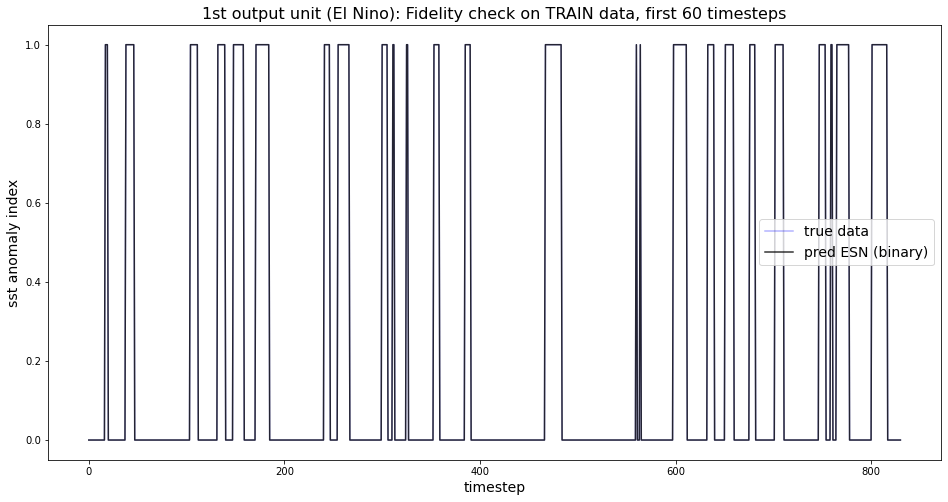

In [63]:
# Fidelity check for binary prediction and target for 1st output unit (El Nino).
# Plot train_pred vs. train_targets.
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target_onehot[:,0])),train_target_onehot[:,0],'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred[:,0])),train_pred[:,0],'k',  alpha=0.8, label='pred ESN (binary)')
plt.title('1st output unit (El Nino): Fidelity check on TRAIN data, first 60 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Discussion on classification with coupled baseESN

In this approach each input gridpoint is directly and only coupled to one reservoir unit. Needed reduce input dimensions by a factor of 2 for both, latitude and longitude, to avoid excessive runtime, since we need to compute eigenvalues for reservoir weight matrix and this computation scales with $n_{res}^2$.

**Note:** Working with **un-capped** inputs is not stable, at least for input_length=2 with sigmoid or tanh activation. Thus stick to capping inputs for further experiments!

#### only one timestep, no reservoir recursion

We can use the coupled base ESN to feed input in first timestep and have **no recursion** in reservoir but directly connect to output units. However, this is not found to yield any usefull results, accuracy is below 100% and most importantly don't get any nice relevance maps.

#### play with scaling and activation functions

Best performance is achieved for inputs scaled to [-1,1] with tanh activation.

* Without recursion find already 100% / 98% accuracy on train / validation data, but - as mentioned above - no nice relevance maps.
* Having one additional timestep yields best accuracy (100% / 99%) and very nice relevance maps for both, El Nino and La Nina samples.
* For input_length=3 and 5 we see accuracies dropping to (100% / 96%) and (100% / 95%), still producing very nice relevance maps.

Pick **input_length=2 to be optimal** for the moment, needs to be further investigated with multi-runs on various input lengths.

For comparision: For plain vanilla linear regression we already found train and validation accuracy of (almost) 100%, slightly outperforming our coupled baseESN approach. Plus trained weights from linear regression nicely highlighted Nino3.4 box (--> see **ESN_exp08_LRP.ipynb**). But remember: For linear regression we could feed whole world's sst anomaly fields in its original resolution. With our coupled base ESN approach we *save* some parameters by reducing resolution by a factor of 4, still having almost identical accuracy!

### LRP on coupled baseESN

Nevertheless we are interested in relevance maps from our coupled baseESN. So stick to $T=2$ timesteps and try LRP. In our setup we worked with leak_rate $\alpha=1$ to simplify reservoir state transition to:

$$x(t=1) = act[u(t=1)W_{in}]$$ and $$x(t>1) = act[x(t-1)W_{res}]$$

since we also set input and reservoir biases to zero. Have **onehot** targets. Compute relevance separately for both output units, hence for El Nino / La Nina samples separately. From third part of this experiment (**--> ESN_exp08_LRP_part3.ipynb**) we know to use the following propagation rule to pass information backward from layer $j$ to previous layer $i$:

$$R_i = \sum_j \frac{z_{ij}^+}{\sum_i z_{ij}^+}R_j$$

Here we only take positive contributions of pre-activations $z_{ij}^+ = (a_i w_{ij})^+$ into account. Aim to find some nice and reasonable structure in relevance map, **highlighting Nino region**,.

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 2, 4050)
number of timesteps:  2
number of input features in_feat:  4050
number of res. units n_res:  4050
leak rate alpha:  1
model prediction on sample, 1st output unit (El Nino):  0.076
model prediction on sample, 2nd output unit (La Nina):  0.899

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (4050, 4050)
input biases b_in (res. units):  (4050,)
reservoir weights W_res (res. units, res. units):  (4050, 4050)
reservoir biases b_res (res. units):  (4050,)
output weights W_out (res. units, output features):  (4050, 2)
output biases b_out (output features):  (2,)

Tensor shapes:
input tensor U (timesteps, input features):  (2, 4050)
all res. states X (timesteps, res. units):  (2, 4050)
activations ACT (timesteps, res. units):  (2, 4050)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1067/2314299855.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


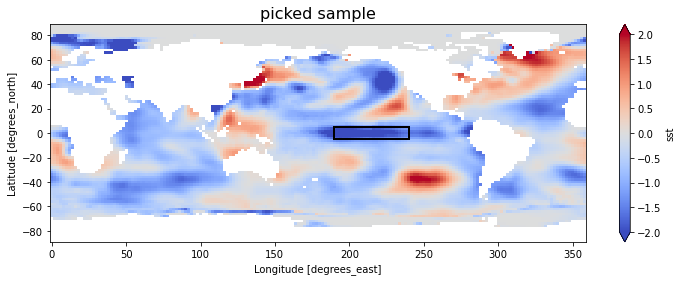

In [119]:
### Pick out ONE El Nino sample to be analysed:
#sample_id = 40 # number 40 of validation inputs --> El Nino sample
sample_id = 52 # number 52 of validation inputs --> La Nina sample
sample = val_input[sample_id:sample_id+1,:]

## If feeding the sample column-wise is desired, need to swap lat <-> lon for input sample:
#sample = np.swapaxes(sample, 1, 2)

# Plot sample input in its original size
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=2, vmin=-2)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample, 1st output unit (El Nino): ", np.round(pred[0,0],3))
print("model prediction on sample, 2nd output unit (La Nina): ", np.round(pred[0,1],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

### Extract input / reservoir / output weights and bias(es):

## Note: Have reservoir weights only in case of input_length > 1, here T > 0.

if T > 0:
    W_in = model_weights[0]
    b_in = model_weights[1]
    W_res = model_weights[2]
    b_res = model_weights[3]
    W_out = model_weights[4]
    b_out = model_weights[5]
    
    ## Check dimensions:
    print("\nModel weights and biases, Dimensions:")
    print("=====================================")
    print("input weights W_in (input features, res. units): ", W_in.shape)
    print("input biases b_in (res. units): ", b_in.shape)
    print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
    print("reservoir biases b_res (res. units): ", b_res.shape)
    print("output weights W_out (res. units, output features): ", W_out.shape)
    print("output biases b_out (output features): ", b_out.shape)

else:
    W_in = model_weights[0]
    b_in = model_weights[1]
    W_out = model_weights[2]
    b_out = model_weights[3]

    ## Check dimensions:
    print("\nModel weights and biases, Dimensions:")
    print("=====================================")
    print("input weights W_in (input features, res. units): ", W_in.shape)
    print("input biases b_in (res. units): ", b_in.shape)
    print("output weights W_out (res. units, output features): ", W_out.shape)
    print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

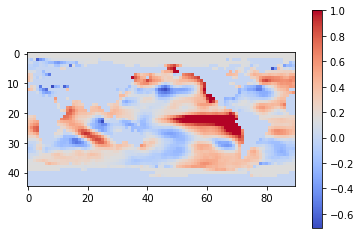

In [116]:
# Plot sample in reduced size:
plt.imshow(sample[0,0,:].reshape((45,90)), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [117]:
### LRP on coupled baseESN: Only take positive contributions of pre-potential into account.
### First output unit: EL NINO

## NOTE: Use first output units prediction!

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

### Only in case of input_lenght > 1, hence T > 0:
if T > 0:    
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i

### In case of of input_length = 1: 
else:    

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_k_sum = []
    R_i_sum.append(sum(R_i))
    R_k_sum.append(sum(R_k))

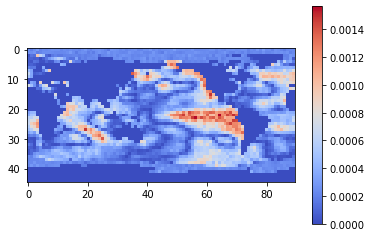

In [118]:
# Plot relevance map for inputs. Note: Inputs had beed flattened, hence need to restore original lat x lon shape.
plt.imshow(R_k.reshape((45,90)), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [120]:
### LRP on coupled baseESN: Only take positive contributions of pre-potential into account.
### Second output unit: LA NINA

## NOTE: Use second output units prediction!

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
       sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
         / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])

### Only in case of input_lenght > 1, hence T > 0:
if T > 0:  
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i
    
### In case of of input_length = 1: 
else:    

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_k_sum = []
    R_i_sum.append(sum(R_i))
    R_k_sum.append(sum(R_k))

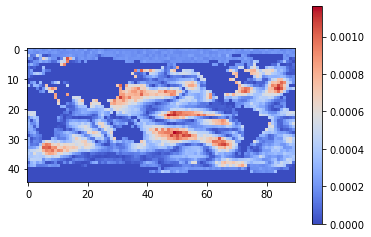

In [121]:
# Plot relevance map for inputs. Note: Inputs had beed flattened, hence need to restore original lat x lon shape.
plt.imshow(R_k.reshape((45,90)), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

### Discussion: LRP with coupled baseESN on onehot targets

Considering **positive pre-activations** for backpropagating relevance yields nice structure in resulting relevance maps for both El Nino and La Nina samples. 

**capping** sst anomaly fields' values to only work with values inside some specified quantile limits **is essentiel**, to enable reasonable scaling of inputs!

#### Artefacts / stripes in relevance map

Don't see any artefacts in terms of stripes, as in other approach with feeding input samples column- or row-wise into base ESN model. But find some coarse grain resolution, as seen for plain vanilla linear regression or MLP.
**--> Could try to work with original resolution of input samples**, but need to find more efficient way to compute eigenvalues of reservoir weights, before. Or switch to HPC!

#### Relevance for La Nina samples

Need to compute relevance maps separately for both output units, hence for El Nino (1st unit) and La Nina (2nd unit) samples.

### Get mean relevance maps for ALL El Nino / La Nina samples (from train inputs)

In [122]:
### LRP with baseESN on ALL El Nino samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input[(train_target_bin==1)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
R_all_mean = np.zeros(in_feat)
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to first OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_k

## Get mean relevance over ALL samples:
R_all_mean_nino = R_all_mean / len(samples_ElNino)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1067/509956027.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  195
sample:  2  from  195
sample:  3  from  195
sample:  4  from  195
sample:  5  from  195
sample:  6  from  195
sample:  7  from  195
sample:  8  from  195
sample:  9  from  195
sample:  10  from  195
sample:  11  from  195
sample:  12  from  195
sample:  13  from  195
sample:  14  from  195
sample:  15  from  195
sample:  16  from  195
sample:  17  from  195
sample:  18  from  195
sample:  19  from  195
sample:  20  from  195
sample:  21  from  195
sample:  22  from  195
sample:  23  from  195
sample:  24  from  195
sample:  25  from  195
sample:  26  from  195
sample:  27  from  195
sample:  28  from  195
sample:  29  from  195
sample:  30  from  195
sample:  31  from  195
sample:  32  from  195
sample:  33  from  195
sample:  34  from  195
sample:  35  from  195
sample:  36  from  195
sample:  37  from  195
sample:  38  from  195
sample:  39  from  195
sample:  40  from  195
sample:  41  from  195
sample:  42  from  195
sample:  43  from  195
sample:  44  from  1

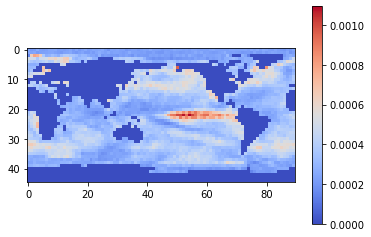

In [123]:
plt.imshow(R_all_mean_nino.reshape((45,90)), cmap='coolwarm', interpolation='nearest')#, vmin=0.0002, vmax=0.0003)
plt.colorbar()
plt.show()

In [124]:
### LRP with baseESN on ALL La Nina samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_LaNina = train_input[(train_target_bin==0)[:,0]]

## Split targets accordingly:
targets_LaNina = train_target[(train_target_bin==0)[:,0]]

if verbose:
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_LaNina.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_LaNina.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
R_all_mean = np.zeros(in_feat)
    
#Loop over El Nino samples:
for sample_id in range(len(samples_LaNina)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_LaNina))
    
    # Get current sample:
    sample = samples_LaNina[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to first OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
           sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
             / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_k

## Get mean relevance over ALL samples:
R_all_mean_nina = R_all_mean / len(samples_LaNina)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1067/1912458537.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  636
sample:  2  from  636
sample:  3  from  636
sample:  4  from  636
sample:  5  from  636
sample:  6  from  636
sample:  7  from  636
sample:  8  from  636
sample:  9  from  636
sample:  10  from  636
sample:  11  from  636
sample:  12  from  636
sample:  13  from  636
sample:  14  from  636
sample:  15  from  636
sample:  16  from  636
sample:  17  from  636
sample:  18  from  636
sample:  19  from  636
sample:  20  from  636
sample:  21  from  636
sample:  22  from  636
sample:  23  from  636
sample:  24  from  636
sample:  25  from  636
sample:  26  from  636
sample:  27  from  636
sample:  28  from  636
sample:  29  from  636
sample:  30  from  636
sample:  31  from  636
sample:  32  from  636
sample:  33  from  636
sample:  34  from  636
sample:  35  from  636
sample:  36  from  636
sample:  37  from  636
sample:  38  from  636
sample:  39  from  636
sample:  40  from  636
sample:  41  from  636
sample:  42  from  636
sample:  43  from  636
sample:  44  from  6

sample:  347  from  636
sample:  348  from  636
sample:  349  from  636
sample:  350  from  636
sample:  351  from  636
sample:  352  from  636
sample:  353  from  636
sample:  354  from  636
sample:  355  from  636
sample:  356  from  636
sample:  357  from  636
sample:  358  from  636
sample:  359  from  636
sample:  360  from  636
sample:  361  from  636
sample:  362  from  636
sample:  363  from  636
sample:  364  from  636
sample:  365  from  636
sample:  366  from  636
sample:  367  from  636
sample:  368  from  636
sample:  369  from  636
sample:  370  from  636
sample:  371  from  636
sample:  372  from  636
sample:  373  from  636
sample:  374  from  636
sample:  375  from  636
sample:  376  from  636
sample:  377  from  636
sample:  378  from  636
sample:  379  from  636
sample:  380  from  636
sample:  381  from  636
sample:  382  from  636
sample:  383  from  636
sample:  384  from  636
sample:  385  from  636
sample:  386  from  636
sample:  387  from  636
sample:  388  fr

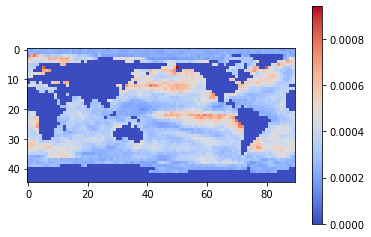

In [125]:
plt.imshow(R_all_mean_nina.reshape((45,90)), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000018)
plt.colorbar()
plt.show()

### Discussion on mean relevance maps

#### El Nino

Find some really nice mean relevance map for El Nino train samples, highlighting Nino3.4 box.
See some stripes as model dependend artefacts. Could reduce artefacts by averaging over multiple baseESN models.

#### La Nina

Mean relevance map for La Nina train samples is somewhat blurrier and has no real highlights. However, [Toms et al., 2020] only show mean relevance for El Nino samples, they might have had the same problem. ;-)